## Quantum Dynamics of the Transverse-Field Ising Model using Trotterization and Constant-Depth Circuits

In this notebook, we demonstrate how to generate the constant-depth circuits for dynamic simulation of the transverse field Ising model (TFIM) using the circuit synthesis software QSearch, which is part of the **[BQSKit](https://bqskit.lbl.gov/)** tookit.  More details on our constant-depth circuits can be found in our **[paper](https://arxiv.org/abs/2103.07429)**.  We also prepare analgous circuits using IBM's general purpose compiler and show how our circuits perform better on currently available quantum computers.

### Import necessary libraries
First we download the necessary libraries.  See instructions for downloading **[numpy](https://numpy.org/install/)**, **[matplotlib](https://matplotlib.org/stable/users/installing.html)**, **[QSearch](https://github.com/BQSKit/qsearch)**, or **[Qiskit](https://qiskit.org/documentation/install.html)** if you don't already have them installed on your compuer.

In [13]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.optimize import minimize
from scipy.linalg import norm

# Qiskit import
import qiskit as qc

# Pennylane import
import pennylane as qml

### System parameters
Next, we define the parameters of the system and the simulation we wish to run. Here, we will be performing a quantum quench of a TFIM.  Set the number of desired qubits; the coupling constant Jx; the strength and frequency of the transverse field hz and freq, respectively; the time-step size; the number of time-steps; and the number of shots for performing experiments on the quantum simulator or the real quantum hardware.

In [14]:
## Define simulation parameters for TFIM

N = 3  # number of spins/qubits

# TFIM Simulation parameters
Jx = 0.01183898
hz = 2.0 * Jx
freq = 0.0048
delta_t = 3     # time-step size
num_steps = 40  # number of time-steps, we start with a small number for speed of demonstration
shots = 8192    # number of shots for circuit execution

In [15]:
## Define the pennylane devices

dev_qubit = qml.device("default.qubit", wires=N)
dev_mixed = qml.device("default.mixed", wires=N)
# dev_gpu = qml.device('lightning.gpu', wires=N) 
# dev_qiskit = qml.device("qiskit.remote", wires=2, backend=backend)

In [41]:
## Global variables

trotter_sim_results = []
trotter_ckt_depth_sim = []
trotter_ckt_cnot_sim = []

constant_depth_sim_results = []
cd_ckt_depth_sim = []
cd_ckt_cnot_sim = []

### Generating the high-level circuits
Next, we generate the high-level circuits for simulating the dynamics of the TFIM model.  These circuits will be used to create our constant-depth circuits, as well as used with the IBM general-purpose circuit compiler for comparison.

### Simulate the Trotter circuits and Generate the Target Unitary Matrices
For comparison, we generate circuits using IBM's general-purpose quantum circuit compiler.  These circuits will not be constant in depth with increasing numbers of time-steps.

In [46]:
from helper import evolution_circuit_TFIM


## Simulating the TFIM Hamiltonian using Trotter decomposition

trotter_sim_results = []
target_unitaries = []


@qml.qnode(dev_qubit)
def trotter_ckt(t, Jx, hz, freq, delta_t, N):
    # initial state is ground state of XX
    for q in range(0, N):
        qml.Hadamard(q)
    qml.Barrier(wires=range(N))
    # circuit for evolution under the TFIM Hamiltonian
    evolution_circuit_TFIM(t, Jx, hz, freq, delta_t, N)
    # measuring the expectation value of the PauliX operators
    return [qml.expval(qml.PauliX(wires=i)) for i in range(N)]


for t in range(num_steps + 1):
    # Generate target unitary matrix for given time step
    target_unitaries.append(qml.matrix(trotter_ckt)(t, Jx, hz, freq, delta_t, N))
    # Simulate the Trotter circuit
    exp_vals = trotter_ckt(t, Jx, hz, freq, delta_t, N)
    # Taking the mean of the expectation values = average magnetization
    result = np.mean(exp_vals)
    # Store the results
    trotter_sim_results.append(result)
    trotter_ckt_depth_sim.append(qml.specs(trotter_ckt)(t, Jx, hz, freq, delta_t, N)["resources"].depth)
    trotter_ckt_cnot_sim.append(qml.specs(trotter_ckt)(t, Jx, hz, freq, delta_t, N)["resources"].gate_types['CNOT'])


print(trotter_sim_results)

[np.float64(0.9999999999999994), np.float64(0.9768443411931124), np.float64(0.9097048747554184), np.float64(0.8051319622235207), np.float64(0.6727348231455474), np.float64(0.5236226340550747), np.float64(0.36884746073999225), np.float64(0.21816041938649647), np.float64(0.07923108892695115), np.float64(-0.042672613581665166), np.float64(-0.14463995473403088), np.float64(-0.2258328888379784), np.float64(-0.28707419627196856), np.float64(-0.33039466117030014), np.float64(-0.35859997067620225), np.float64(-0.374896181540978), np.float64(-0.3825930863083835), np.float64(-0.38488653379447496), np.float64(-0.38470473969432134), np.float64(-0.3845921608747708), np.float64(-0.3865999612296474), np.float64(-0.392156284580095), np.float64(-0.40190351134771096), np.float64(-0.41551308521663316), np.float64(-0.43151827260204284), np.float64(-0.44723374394058996), np.float64(-0.45884536238045487), np.float64(-0.4617389385536074), np.float64(-0.45108338371404827), np.float64(-0.42259846339664203), np

(<Figure size 1700x400 with 1 Axes>, <Axes: >)

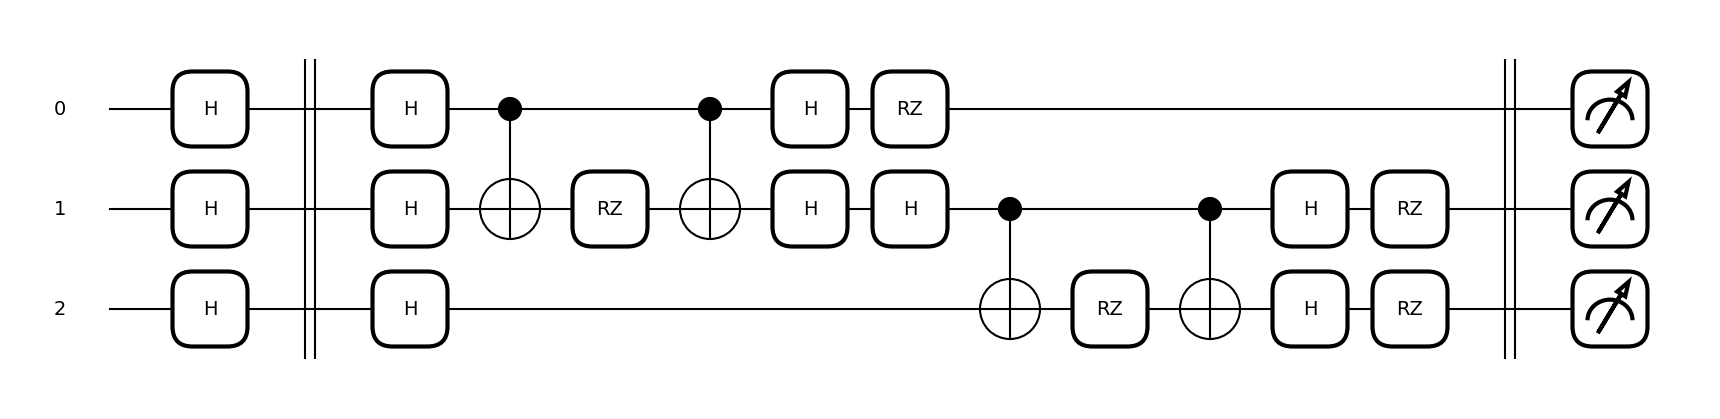

In [17]:
## Drawing a circuit for a single time step of the TFIM Hamiltonian Simulation

qml.draw_mpl(trotter_ckt)(1, Jx, hz, freq, delta_t, N)

### Define functions for generating the constant-depth circuit structure

In [23]:
from matchgates import make_layertype1, make_layertype2


## Define the matchgate circuit

@qml.qnode(dev_qubit)
def make_MGC(N, params):
    """
    Make matchgate circuit for N qubits.
    """
    for l in range(N):
        # add layer_type1
        if l % 2 == 0:
            make_layertype1(N, params)
        # add layer_type2
        else:
            make_layertype2(N, params)
    return [qml.expval(qml.PauliX(wires=i)) for i in range(N)]

(<Figure size 3500x500 with 1 Axes>, <Axes: >)


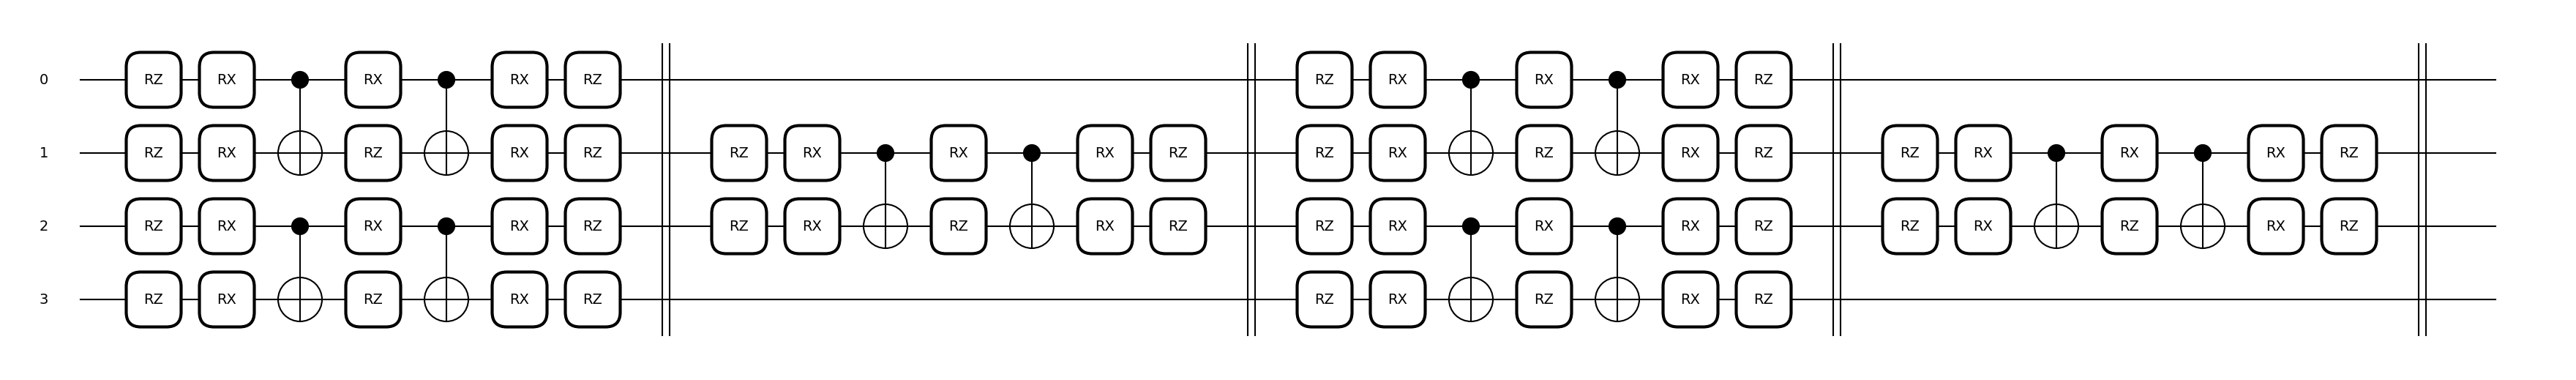

In [19]:
## Draw a circuit for the matchgate circuit (Tetsing)

print(qml.draw_mpl(make_MGC)(4, [0.1] * 10))

### Generate the constant-depth circuits
The constant-depth circuits are generating by computing the target unitary matrix from the high-level circuits and the constant-depth circuit structure.  Given the target unitary and the constant-depth circuit structure, QSearch can optimize the parameters in the constant-depth circuit, which are written to a file for future use.


**Synthesis**

Numerical quantum synthesis, as used in BQSKit, is the process of implementing a quantum circuit from a given unitary matrix, which completely describes the target operation. You can use the standard compile function to synthesis a unitary by simply passing one in:

In [24]:
## Define the cost function caluclating the distance (= 1 - fidelity) between 
## the target and current unitary matrices

def cost(params):
    current_unitary = qml.matrix(make_MGC)(N, params)
    ## Calculate Frobenius distance
    # distance = norm(target_unitary - current_unitary, 'fro')
    distance = np.abs(
        1 - np.abs(np.sum(np.multiply(current_unitary, np.conj(target_unitary))))
        / current_unitary.shape[0]
    )
    return distance

In [25]:
## Find the best parameters for matchgates for each time step

num_random_starts = 3  # How many random initial guesses
tolerance = 1e-10  # Target final distance
final_params = []

for t in range(num_steps + 1):
    # Get the target unitary from Qiskit
    target_unitary = target_unitaries[t]

    # Set the initial parameters
    init_params = [None] * 10
    best_distance = np.inf
    best_params = None

    # Multi-start optimization loop
    for _ in range(num_random_starts):
        # Random initial guess
        # init_params = 2 * np.pi * (np.random.rand(len(init_params)) - 0.5)
        init_params = np.array([random.random() for _ in range(len(init_params))])

        # Minimize the cost function
        result = minimize(cost, init_params, method="L-BFGS-B", tol=tolerance)

        if result.fun < best_distance:
            best_distance = result.fun
            best_params = result.x

        # Early stopping
        if best_distance < tolerance:
            break

    # Save the best found parameters
    final_params.append(best_params)
    print(f"Time step {t}: best achieved distance {best_distance:.2e}")

Time step 0: best achieved distance 4.48e-01
Time step 1: best achieved distance 4.13e-01
Time step 2: best achieved distance 3.79e-01
Time step 3: best achieved distance 3.48e-01
Time step 4: best achieved distance 3.20e-01
Time step 5: best achieved distance 2.96e-01
Time step 6: best achieved distance 2.74e-01
Time step 7: best achieved distance 2.54e-01
Time step 8: best achieved distance 2.35e-01
Time step 9: best achieved distance 3.71e-01
Time step 10: best achieved distance 2.04e-01
Time step 11: best achieved distance 3.69e-01
Time step 12: best achieved distance 3.92e-01
Time step 13: best achieved distance 3.92e-01
Time step 14: best achieved distance 3.14e-01
Time step 15: best achieved distance 3.17e-01
Time step 16: best achieved distance 3.26e-01
Time step 17: best achieved distance 4.54e-01
Time step 18: best achieved distance 3.53e-01
Time step 19: best achieved distance 3.69e-01
Time step 20: best achieved distance 5.14e-01
Time step 21: best achieved distance 5.92e-0

### Simulating the constant-depth circuits on Pennylane

In [47]:
## Simulating the constant-depth circuits for given time-steps on pennylane

constant_depth_sim_results = []


@qml.qnode(dev_qubit)
def constant_depth_circuit(N, params):
    """
    Builds the full quantum circuit given the input parameters
    """
    # initial state is ground state of XX
    for q in range(0, N):
        qml.Hadamard(q)
    qml.Barrier(wires=range(N))
    # add matchgate circuit
    for l in range(N):
        # add layer_type1
        if l % 2 == 0:
            make_layertype1(N, params)
        # add layer_type2
        else:
            make_layertype2(N, params)
    # measuring the expectation value of the PauliX operators
    return [qml.expval(qml.PauliX(wires=i)) for i in range(N)]


for t in range(num_steps + 1):
    # Simulate the constant-depth circuit
    exp_vals = constant_depth_circuit(N, final_params[t])
    # Taking the mean of the expectation values = average magnetization
    result = np.mean(exp_vals)
    constant_depth_sim_results.append(result)
    cd_ckt_depth_sim.append(qml.specs(constant_depth_circuit)(N, final_params[t])["resources"].depth)
    cd_ckt_cnot_sim.append(qml.specs(constant_depth_circuit)(N, final_params[t])["resources"].gate_types['CNOT'])


print(constant_depth_sim_results)

[np.float64(0.2947041467261527), np.float64(0.301663914895802), np.float64(0.29537741335680495), np.float64(0.27513365812268614), np.float64(0.24403299075491744), np.float64(0.20847868597857708), np.float64(0.1764257758539416), np.float64(0.154486770245267), np.float64(0.144762916992109), np.float64(0.03295593714058768), np.float64(0.14890111162047004), np.float64(-0.09367896959550466), np.float64(-0.12972173224229275), np.float64(0.35238321017674007), np.float64(0.075205170603923), np.float64(0.0414978213345635), np.float64(0.009387135504793809), np.float64(-0.0751142957368743), np.float64(-0.04934149403520025), np.float64(-0.0717353687956928), np.float64(-0.07026277719625683), np.float64(-0.17944007510246296), np.float64(0.03592890649601571), np.float64(0.3941084802215824), np.float64(0.2444976047070694), np.float64(0.2890167895091553), np.float64(0.30803950940332353), np.float64(0.30942821575711227), np.float64(0.3941817651264838), np.float64(0.48438185849196547), np.float64(-0.0754

### Post-processing
To post-process the results from the quantum backends, we define a function to compute the average magnetization for each time-step from the results of the quantum backend.  

### Plot Results

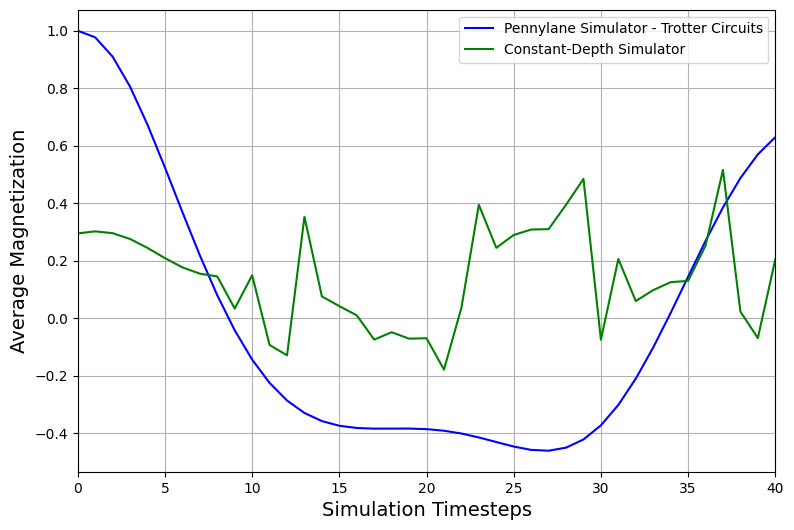

In [49]:
## Plotting the results - Average Magnetization vs. time-steps

plt.figure(figsize=(9, 6))
plt.plot(trotter_sim_results, label="Pennylane Simulator - Trotter Circuits", color="blue")
plt.plot(constant_depth_sim_results, label="Constant-Depth Simulator", color="green")
plt.xlim(0,40)
# plt.ylim(-1.0, 1.0)
plt.xlabel("Simulation Timesteps", fontsize=14)
plt.ylabel("Average Magnetization", fontsize=14)
plt.grid()
plt.legend(loc="upper right", fontsize=10)
plt.show()
# plt.savefig(f'{N}q_TFIM_sim_pennylane.svg', dpi=500)

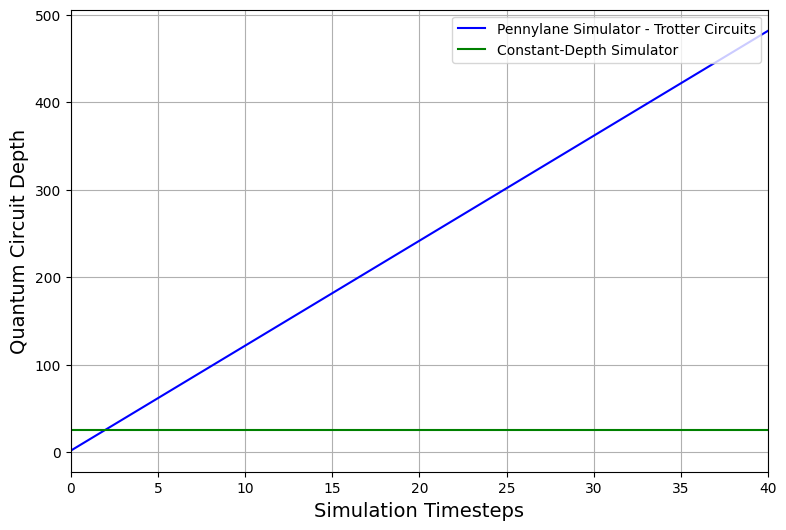

In [52]:
## Plotting the circuit depth vs. time-steps

plt.figure(figsize=(9, 6))
plt.plot(trotter_ckt_depth_sim, label="Pennylane Simulator - Trotter Circuits", color="blue")
plt.plot(cd_ckt_depth_sim, label="Constant-Depth Simulator", color="green")
plt.xlim(0,40)
# plt.ylim(-1.0, 1.0)
plt.xlabel("Simulation Timesteps", fontsize=14)
plt.ylabel("Quantum Circuit Depth", fontsize=14)
plt.grid()
plt.legend(loc="upper right", fontsize=10)
plt.show()
# plt.savefig(f'{N}q_TFIM_sim_pennylane.svg', dpi=500)

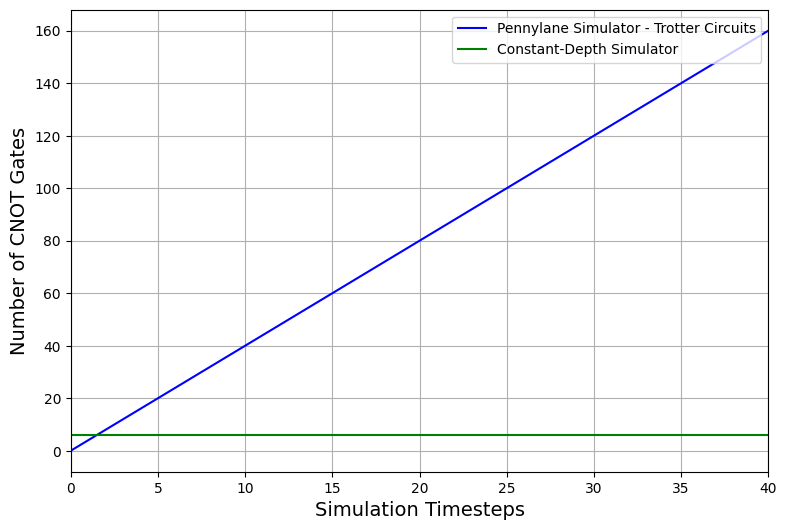

In [53]:
## Plotting the circuit depth vs. time-steps

plt.figure(figsize=(9, 6))
plt.plot(trotter_ckt_cnot_sim, label="Pennylane Simulator - Trotter Circuits", color="blue")
plt.plot(cd_ckt_cnot_sim, label="Constant-Depth Simulator", color="green")
plt.xlim(0,40)
# plt.ylim(-1.0, 1.0)
plt.xlabel("Simulation Timesteps", fontsize=14)
plt.ylabel("Number of CNOT Gates", fontsize=14)
plt.grid()
plt.legend(loc="upper right", fontsize=10)
plt.show()
# plt.savefig(f'{N}q_TFIM_sim_pennylane.svg', dpi=500)